In [22]:
path = ""

In [23]:
# ## UNCOMMENT THIS CELL IF USING GOOGLE COLAB ###

# from google.colab import drive

# drive.mount('/content/drive', force_remount=True)

# # Enter the path in your Drive..
# FOLDERNAME = "ViT"

# assert FOLDERNAME is not None, "[!] Enter the foldername."

# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append(f'/content/drive/My Drive/{FOLDERNAME}')

# path = f'/content/drive/My Drive/{FOLDERNAME}'

In [24]:
!pip install datasets

%load_ext autoreload
%autoreload 2

import os
import torch
import torchvision
import matplotlib.pyplot as plt
from utils import *
from model import Transformer
from datasets import load_dataset
from dataset import ImageNet
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:0



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
tiny_imagenet_dataset = load_dataset("zh-plus/tiny-imagenet", cache_dir="dataset")

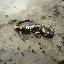

In [26]:
tiny_imagenet_dataset["train"][500]["image"]

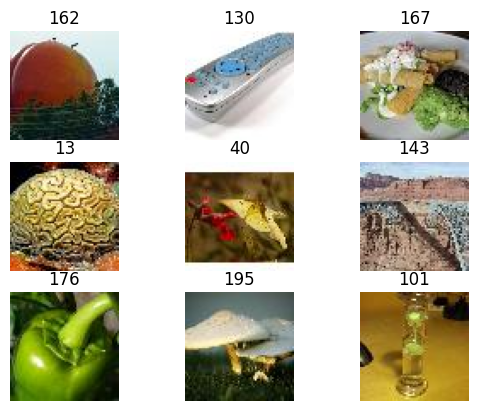

In [27]:
show_samples(tiny_imagenet_dataset["train"])

In [28]:
(H, W, C) = get_image_shape(tiny_imagenet_dataset["train"][500]["image"])

print((H, W, C))

(64, 64, 3)


In [29]:
P = 16
N = (H*W)//(P**2)

print((P,N))

(16, 16)


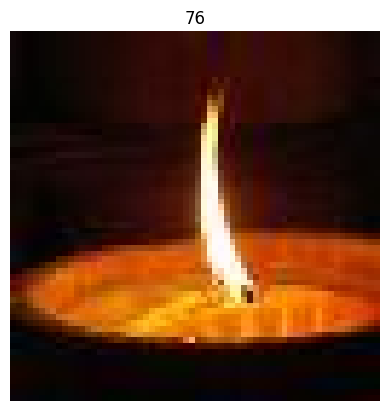

In [30]:
idx = np.random.randint(low = 0, high = len(tiny_imagenet_dataset["train"]))
test_image = tiny_imagenet_dataset["train"][idx]
show_image(test_image)

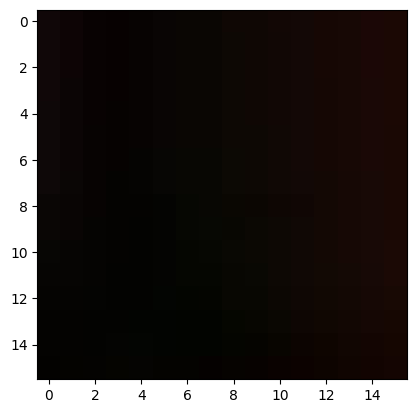

In [31]:
patches_test = images_to_patches([test_image["image"]], res_patch = 16)
plt.imshow(patches_test[0,0])
plt.show()

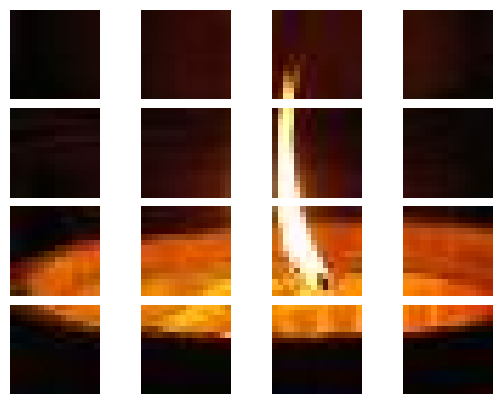

In [32]:
show_patches(patches_test[0])

torch.Size([1, 16, 768])
torch.Size([1, 16, 16, 16, 3])


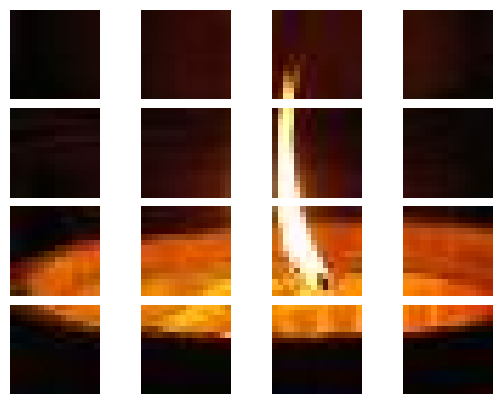

In [33]:
flat_patches = flatten_patches(patches_test)
print(flat_patches.shape)

patches = flat_to_patches(flat_patches, N = 16, P = 16, C = 3)
print(patches.shape)

show_patches(patches[0])

In [34]:
val_ratio = 0.3
splitted = tiny_imagenet_dataset["train"].train_test_split(val_ratio)
print(splitted)
imagenet_train = ImageNet(data = splitted["train"],
                         to_paches_fn = images_to_patches,
                         res_patch = 16)

imagenet_val = ImageNet(data = splitted["test"],
                         to_paches_fn = images_to_patches,
                         res_patch = 16)

imagenet_test = ImageNet(data = tiny_imagenet_dataset["valid"],
                         to_paches_fn = images_to_patches,
                         res_patch = 16)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 70000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 30000
    })
})


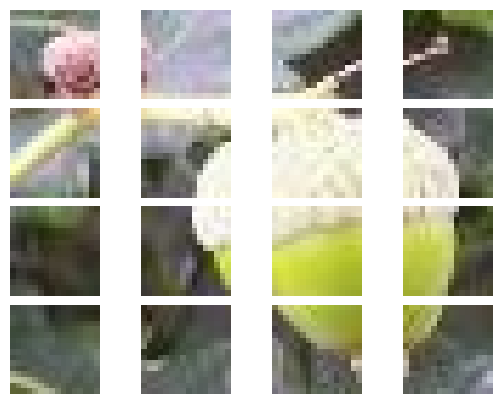

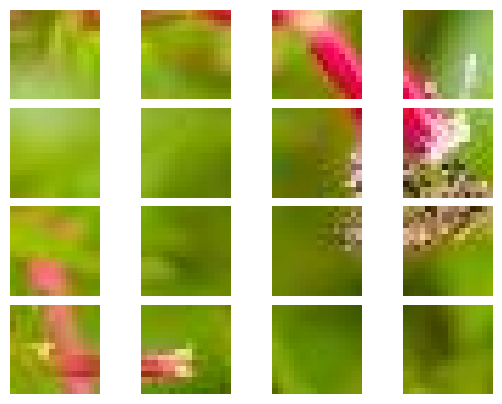

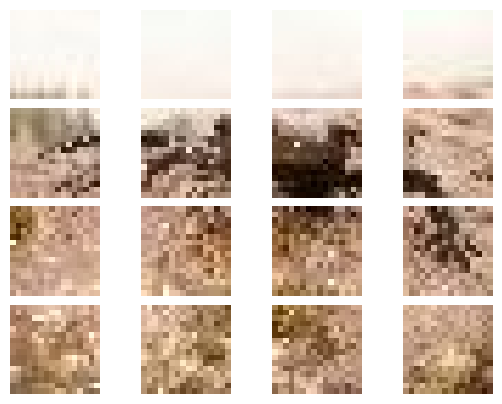

In [35]:
show_patches(flat_to_patches(imagenet_train[50]["image_patches_flatten"], N = 16, P = 16, C = 3)[0])
show_patches(flat_to_patches(imagenet_val[50]["image_patches_flatten"], N = 16, P = 16, C = 3)[0])
show_patches(flat_to_patches(imagenet_test[50]["image_patches_flatten"], N = 16, P = 16, C = 3)[0])

inputs batch shape: torch.Size([1024, 1, 16, 768])
labels batch shape: torch.Size([1024])
label : 181


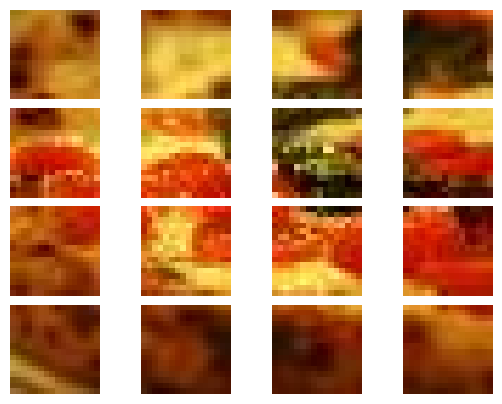

In [36]:
batch_size = 1024
trainLoaders = {}

train_dataloader = DataLoader(imagenet_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(imagenet_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(imagenet_test, batch_size=batch_size, shuffle=True)

trainLoaders["train"] = train_dataloader
trainLoaders["val"] = val_dataloader


## Generating an example ##
for i,batch in enumerate(iter(train_dataloader)):

    inputs,targets = batch["image_patches_flatten"],batch["label"]
    idx = np.random.randint(0,len(inputs))
    if i < 1:
        print(f"inputs batch shape: {inputs.size()}")
        print(f"labels batch shape: {targets.size()}")
        sample = (inputs[idx],targets[idx])
        
        print(f"label : {sample[1]}")
        show_patches(flat_to_patches(sample[0], N = 16, P = 16, C = 3)[0])
        
        break

In [37]:
model = Transformer(image_features_dim = (P**2)*C, no_classes = 1000, src_max_len = N, noHeads = 12, d_model = 768, d_ff = 3072, 
                 dropout = 0.1, noEncoder = 2, device =device).to(device)

In [38]:
print(f"Numeber of the model's trainable paramaters : {count_parameters(model)}")

Numeber of the model's trainable paramaters : 15543016


In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [40]:
## An example of the untrained model prediction ##
out = model(imagenet_val[:10]["image_patches_flatten"])
print(out.shape)

print(f"True label : {imagenet_train[:10]['label']}")
print(f"Prediction : {torch.argmax(torch.softmax(out,dim = -1),dim = 1)}")

## The prediction loss ##
loss = classificationLoss(output=out, target=torch.tensor([imagenet_train[:10]['label']]).to(device))
print(loss)

acc = score(out, torch.tensor([imagenet_train[:10]['label']]).to(device), kind = "accuracy")
print(acc)

torch.Size([10, 1000])
True label : [182, 183, 50, 135, 190, 153, 9, 84, 39, 62]
Prediction : tensor([816, 509, 509, 115, 509, 509, 355, 509, 509, 509], device='cuda:0')
tensor(7.5974, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0., device='cuda:0')


In [41]:
if not (os.path.exists("trained")):
        os.mkdir("trained")

filename = "vit-weights-base"

In [42]:
train_cum_losses, val_cum_losses = [], []

In [43]:
trainedModel, train_losses, val_losses = train_model(model, trainLoaders, classificationLoss, 
                           optimizer, num_epochs=10, device = device, isSave=True,
                           filename = filename, verbose = False)

train_cum_losses += train_losses
val_cum_losses += val_losses

torch.save(trainedModel.state_dict(), f"trained/{filename}")
# !cp -r './trained/transformer-weights-small' /content/drive/MyDrive/

Epoch 0/9
----------


Predicting ...:   0%|          | 0/69 [00:00<?, ?it/s]

train prev epoch Loss: 0
train current epoch Loss: 5494.019934944485, lr = 0.001


Predicting ...:   0%|          | 0/30 [00:00<?, ?it/s]

val prev epoch Loss: 0
val current epoch Loss: 5184.073941294352, lr = 0.001
Epoch 1/9
----------


Predicting ...:   0%|          | 0/69 [00:00<?, ?it/s]

train prev epoch Loss: 5494.019934944485
train current epoch Loss: 5161.607325346574, lr = 0.001


Predicting ...:   0%|          | 0/30 [00:00<?, ?it/s]

val prev epoch Loss: 5184.073941294352
val current epoch Loss: 4960.743423716227, lr = 0.001
Epoch 2/9
----------


Predicting ...:   0%|          | 0/69 [00:00<?, ?it/s]

train prev epoch Loss: 5161.607325346574
train current epoch Loss: 4990.784106047257, lr = 0.001


Predicting ...:   0%|          | 0/30 [00:00<?, ?it/s]

val prev epoch Loss: 4960.743423716227
val current epoch Loss: 4880.095591227214, lr = 0.001
Epoch 3/9
----------


Predicting ...:   0%|          | 0/69 [00:00<?, ?it/s]

train prev epoch Loss: 4990.784106047257
train current epoch Loss: 4885.747406337572, lr = 0.001


Predicting ...:   0%|          | 0/30 [00:00<?, ?it/s]

val prev epoch Loss: 4880.095591227214
val current epoch Loss: 4808.088755289714, lr = 0.001
Epoch 4/9
----------


Predicting ...:   0%|          | 0/69 [00:00<?, ?it/s]

train prev epoch Loss: 4885.747406337572
train current epoch Loss: 4807.69964323182, lr = 0.001


Predicting ...:   0%|          | 0/30 [00:00<?, ?it/s]

val prev epoch Loss: 4808.088755289714
val current epoch Loss: 4753.818825276693, lr = 0.001
Epoch 5/9
----------


Predicting ...:   0%|          | 0/69 [00:00<?, ?it/s]

train prev epoch Loss: 4807.69964323182
train current epoch Loss: 4741.856724614682, lr = 0.001


Predicting ...:   0%|          | 0/30 [00:00<?, ?it/s]

val prev epoch Loss: 4753.818825276693
val current epoch Loss: 4739.610125986735, lr = 0.001
Epoch 6/9
----------


Predicting ...:   0%|          | 0/69 [00:00<?, ?it/s]

train prev epoch Loss: 4741.856724614682
train current epoch Loss: 4686.265880750573, lr = 0.001


Predicting ...:   0%|          | 0/30 [00:00<?, ?it/s]

val prev epoch Loss: 4739.610125986735
val current epoch Loss: 4725.297324371338, lr = 0.001
Epoch 7/9
----------


Predicting ...:   0%|          | 0/69 [00:00<?, ?it/s]

train prev epoch Loss: 4686.265880750573
train current epoch Loss: 4631.196283644525, lr = 0.001


Predicting ...:   0%|          | 0/30 [00:00<?, ?it/s]

val prev epoch Loss: 4725.297324371338
val current epoch Loss: 4689.091470591227, lr = 0.001
Epoch 8/9
----------


Predicting ...:   0%|          | 0/69 [00:00<?, ?it/s]

train prev epoch Loss: 4631.196283644525
train current epoch Loss: 4577.1474685668945, lr = 0.001


Predicting ...:   0%|          | 0/30 [00:00<?, ?it/s]

val prev epoch Loss: 4689.091470591227
val current epoch Loss: 4594.153538767497, lr = 0.001
Epoch 9/9
----------


Predicting ...:   0%|          | 0/69 [00:00<?, ?it/s]

train prev epoch Loss: 4577.1474685668945
train current epoch Loss: 4513.753171063851, lr = 0.001


Predicting ...:   0%|          | 0/30 [00:00<?, ?it/s]

val prev epoch Loss: 4594.153538767497
val current epoch Loss: 4586.107384236654, lr = 0.001

Training complete in 47m 33s
Best val loss: 4586.107384


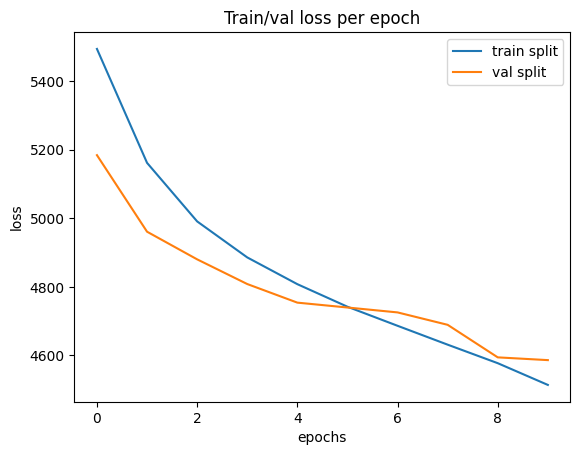

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(np.arange(len(train_cum_losses)), train_cum_losses, label = 'train split')
ax.plot(np.arange(len(val_cum_losses)), val_cum_losses, label = "val split")

ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.set_title("Train/val loss per epoch")
ax.legend()

plt.show()

In [45]:
results = evaluate_model(model, train_dataloader, device = device)

Predicting ...:   0%|          | 0/69 [00:00<?, ?it/s]

 Result : 0.0966649204492569

Evaluating complete in 1m 58s


In [31]:
model.load_state_dict(torch.load(os.path.join(path,os.path.join("trained",filename))))

<All keys matched successfully>